# AUV Localization Using Dead Reckoning Techniques with IMU Sensor

In [409]:
#Load Libraries
import numpy as np            
import pandas as pd           
import matplotlib.pyplot as plt  
import scipy                  
import filterpy

%matplotlib inline

## Define Functions

In [410]:
#Calculate Orientation

def calculate_orientation(a_x, a_y, a_z, previous_pitch, previous_roll):
    
    alpha = 0.9999
    
    theta_z = np.arctan2(a_y, a_z)
    theta_x = np.arctan2(a_x, np.sqrt(a_y**2 + a_z**2))
    pitch = (previous_pitch * alpha) + (theta_x * (1 - alpha))
    roll = (previous_roll * alpha) + (theta_z * (1 - alpha))
    
    return pitch, roll

In [411]:
#Calculate Velocity

def calculate_velocity(a_x, a_y, a_z, previous_velocity_x, previous_velocity_y, previous_velocity_z, delta_t):
    
    velocity_x = previous_velocity_x + a_x * delta_t
    velocity_y = previous_velocity_y + a_y * delta_t
    velocity_z = previous_velocity_z + a_z * delta_t
    
    return velocity_x, velocity_y, velocity_z

In [412]:
#Calculate Position

def calculate_position(previous_position_x, previous_position_y, velocity_x, velocity_y, delta_t):
    
    position_x = previous_position_x + velocity_x * delta_t
    position_y = previous_position_y + velocity_y * delta_t

    return position_x, position_y

In [413]:
# Kalman Filter

def run_kalman_filter(data_in, dt, var):
    # Transition matrix
    F = [[1, dt, 0.5*dt**2], 
         [0,  1,       dt],
         [0,  0,        1]]
    
    # Observation matrix
    H = [0, 0, 1]
    
    # Transition covariance
    Q = [[0.2,    0,      0], 
         [  0,  0.1,      0],
         [  0,    0,  10e-4]]
    
    # Observation covariance
    R = var
    
    # Initial state mean
    X0 = [0, 0, data_in[0]]
    
    # Initial state covariance
    P0 = [[  0,    0,               0], 
          [  0,    0,               0],
          [  0,    0,   var]]
    
    n_timesteps = data_in.shape[0]
    n_dim_state = 3
    filtered_state_means = np.zeros((n_timesteps, n_dim_state))
    filtered_state_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))
    
    kf = KalmanFilter(transition_matrices = F, 
                      observation_matrices = H, 
                      transition_covariance = Q, 
                      observation_covariance = R, 
                      initial_state_mean = X0, 
                      initial_state_covariance = P0)
    
    # Iterative estimation for each new measurement
    for t in range(n_timesteps):
        if t == 0:
            filtered_state_means[t] = X0
            filtered_state_covariances[t] = P0
        else:
            filtered_state_means[t], filtered_state_covariances[t] = (
                kf.filter_update(
                    filtered_state_means[t-1],
                    filtered_state_covariances[t-1],
                    data_in[t]
                )
            )
    return filtered_state_means[:,2]

In [414]:
# Calculate Heading

def calculate_heading(mag_x, mag_y):
    
    heading = np.arctan2(mag_x, mag_y)
    
    return np.degrees(heading)

In [415]:
# Calculate Yaw

def calculate_yaw(mag_x, mag_y):
    
    yaw = np.arctan2(mag_y, mag_x)
    
    return yaw

In [416]:
# Create Rotation Matrix

def create_rotation_matrix(yaw):

    c, s = np.cos(yaw), np.sin(yaw)
    R = np.array([[-c, -s], [-s, c]])  
    
    return R

In [417]:
# Calculate DR

def calculate_dr(acceleration, dt, time_steps):

    ########################
    # Initialize variables #
    ########################
    
    previous_position_x, previous_position_y = 0, 0
    
    previous_velocity_x, previous_velocity_y, previous_velocity_z = 0, 0, 0
    
    previous_pitch_1, previous_roll_1 = 0, 0
    
    velocities_x = []
    velocities_y = []
    velocities_z = []
    
    positions_x = []
    positions_y = []
        
    for i in range(time_steps):
    
        a_x = acceleration['accel_x (m/s^2)'].to_numpy()[i]
        a_y = acceleration['accel_x (m/s^2)'].to_numpy()[i]
        a_z = acceleration['accel_x (m/s^2)'].to_numpy()[i]
         
        pitch, roll = calculate_orientation(a_x, a_y, a_z, previous_pitch, previous_roll)
        velocity_x, velocity_y, velocity_z_1 = calculate_velocity(a_x, a_y, a_z, previous_velocity_x, previous_velocity_y, previous_velocity_z, delta_t)
        position_x, position_y = calculate_position(previous_position_x, previous_position_y, velocity_x, velocity_y, delta_t)
        
        previous_pitch, previous_roll = pitch, roll
        previous_velocity_x, previous_velocity_y, previous_velocity_z = velocity_x, velocity_y, velocity_z
        previous_position_x, previous_position_y = position_x, position_y
              
        velocities_x.append(velocity_x)
        velocities_y.append(velocity_y)
        velocities_z.append(velocity_z)
        
        positions_x.append(position_x)
        positions_y.append(position_y)
    
    initial_velocity = 0
    velocities_x = [initial_velocity] + velocities_x
    velocities_y = [initial_velocity] + velocities_y
    velocities_z = [initial_velocity] + velocities_z

    R = np.array([[0,1],
                 [-1,0]])
    positions = np.vstack((positions_x, positions_y))
    positions_x, positions_y = R @ positions

    return  velocities_x, velocities_y, velocities_z, positions_x, positions_y, a_x, a_y, a_z

In [418]:
def plot_data(time, acceleration, noise_levels):
    
    fig, axs = plt.subplots(4, 1, figsize=(12, 24), constrained_layout=True)
    dt = np.diff(time)[0]
    time_steps = len(time)
    
    # Plot acceleration and velocity for each noise level
    for noise_level in noise_levels:
        # Add noise to acceleration data
        noisy_accel = acceleration + np.random.normal(0, noise_level, acceleration.shape)
        
        # Run Kalman filter on noisy data
        filtered_accel = run_kalman_filter(noisy_accel, dt, var=noise_level**2)

        # Calculate velocity and position from filtered data
        velocities_x, velocities_y, velocities_z, positions_x, positions_y, a_x, a_y, a_z = calculate_dr(filtered_accel, dt, time_steps)

        # Plot acceleration
        axs[0].plot(time, noisy_accel, label=f'Filtered Acceleration- Noise lvl: {noise_level}', linestyle='-', zorder=1)
        
        # Plot velocity
        axs[1].plot(time, velocities, label=f'Calculated Velocity: Noise level: {noise_level}', linestyle='-')

    # Plot ground truth acceleration for comparison
    axs[0].plot(time, acceleration, label='Ground Truth Acceleration', color='black', zorder=2)

    # Set titles and labels
    axs[0].set_title('Acceleration')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Acceleration')
    axs[0].legend()

    axs[1].set_title('Velocity')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Velocity')
    axs[1].legend()

    # Add other plots as needed

    plt.show()

## Load Data

In [419]:
# Load the data from the provided files
accel_data = pd.read_csv('.//2023-11-17-15-11-06//accel-0.csv')
gps_time_data = pd.read_csv('.//2023-11-17-15-11-06//gps_time.csv')
gps_visibility_data = pd.read_csv('.//2023-11-17-15-11-06//gps_visibility.csv')
gps_data = pd.read_csv('.//2023-11-17-15-11-06//gps-0.csv')
gyro_data = pd.read_csv('.//2023-11-17-15-11-06//gyro-0.csv')
mag_data = pd.read_csv('.//2023-11-17-15-11-06//mag-0.csv')
time_data = pd.read_csv('.//2023-11-17-15-11-06//time.csv')

In [420]:
a_x_1r = accel_data['accel_x (m/s^2)'].to_numpy()
a_y_1r = accel_data['accel_y (m/s^2)'].to_numpy()
a_z_1r = accel_data['accel_z (m/s^2)'].to_numpy()

noise_level = 0.05  # Adjust as needed
a_x_1n = a_x_1r + np.random.normal(0, noise_level, a_x_1r.shape)
a_y_1n = a_y_1r + np.random.normal(0, noise_level, a_y_1r.shape)
a_z_1n = a_z_1r + np.random.normal(0, noise_level, a_z_1r.shape)

# Adding noise to create '2' data (low precision)
noise_level = 0.25  # Adjust as needed
a_x_2n = a_x_1r + np.random.normal(0, noise_level, a_x_1r.shape)
a_y_2n = a_y_1r + np.random.normal(0, noise_level, a_y_1r.shape)
a_z_2n = a_z_1r + np.random.normal(0, noise_level, a_z_1r.shape)

# GPS velocity data
gps_vN = gps_data['gps_vN (m/s)'].to_numpy()
gps_vE = gps_data['gps_vE (m/s)'].to_numpy()
gps_vD = gps_data['gps_vD (m/s)'].to_numpy()

# Time data
Time = time_data['time (sec)'].to_numpy()

## Apply Filter

In [421]:
# Apply filter to Acceleration Data
filtered_a_x_1 = run_kalman_filter(a_x_1n, dt, var=0.0007)
filtered_a_y_1 = run_kalman_filter(a_y_1n, dt, var=0.0007)
filtered_a_z_1 = run_kalman_filter(a_z_1n, dt, var=0.0007)

filtered_a_x_2 = run_kalman_filter(a_x_2n, dt, var=0.0020)
filtered_a_y_2 = run_kalman_filter(a_y_2n, dt, var=0.0020)
filtered_a_z_2 = run_kalman_filter(a_z_2n, dt, var=0.0020)

In [422]:
# Assuming 'a_x_1n', 'a_y_1n', and 'a_z_1n' are your noisy accelerometer data arrays
# And 'mag_data' contains your magnetometer data

# Initialize arrays to hold transformed acceleration data
filtered_accel_ned_1 = np.zeros((len(a_x_1n), 3))
filtered_accel_ned_2 = np.zeros((len(a_x_2n), 3))

for i in range(len(a_x_1n)):
    yaw = calculate_yaw(mag_csv['mag_x (uT)'][i], mag_csv['mag_y (uT)'][i])
    R = create_rotation_matrix(yaw)
    
    # Rotate the filtered acceleration vector (only x and y components) for IMU 1
    accel_body_1 = np.array([a_x_1n[i], a_y_1n[i]])
    accel_ned_1 = R @ accel_body_1
    filtered_accel_ned_1[i, :2] = accel_ned_1  # Corrected array name and indexing
    filtered_accel_ned_1[i, 2] = a_z_1n[i]    # Z component remains the same
    
    # Rotate the filtered acceleration vector (only x and y components) for IMU 2
    accel_body_2 = np.array([a_x_2n[i], a_y_2n[i]])
    accel_ned_2 = R @ accel_body_2
    filtered_accel_ned_2[i, :2] = accel_ned_2  # Corrected array name and indexing
    filtered_accel_ned_2[i, 2] = a_z_2n[i]    # Z component remains the same

# Now 'filtered_accel_ned_1' and 'filtered_accel_ned_2' contain the filtered acceleration data in the NED frame.


## Calculate Velocities and Positions

In [430]:
previous_position_x_1, previous_position_y_1 = 0, 0
previous_position_x_2, previous_position_y_2 = 0, 0

previous_velocity_x_1, previous_velocity_y_1, previous_velocity_z_1 = 0, 0, 0
previous_velocity_x_2, previous_velocity_y_2, previous_velocity_z_2 = 0, 0, 0

previous_pitch_1, previous_roll_1 = 0, 0
previous_pitch_2, previous_roll_2 = 0, 0

velocities_x_1 = []
velocities_y_1 = []
velocities_z_1 = []

positions_x_1 = []
positions_y_1 = []

velocities_x_2 = []
velocities_y_2 = []
velocities_z_2 = []

positions_x_2 = []
positions_y_2 = []

for i in range(time_steps):

    a_x_1, a_y_1, a_z_1 = filtered_accel_ned_1[i]
    a_x_2, a_y_2, a_z_2 = filtered_accel_ned_2[i]

    ##########################
    # Calculate DR for IMU 1 #
    ##########################
     
    pitch_1, roll_1 = calculate_orientation(a_x_1, a_y_1, a_z_1, previous_pitch_1, previous_roll_1)
    velocity_x_1, velocity_y_1, velocity_z_1 = calculate_velocity(a_x_1, a_y_1, a_z_1, previous_velocity_x_1, previous_velocity_y_1, previous_velocity_z_1, delta_t)
    position_x_1, position_y_1 = calculate_position(previous_position_x_1, previous_position_y_1, velocity_x_1, velocity_y_1, delta_t)

    ##########################
    # Calculate DR for IMU 2 #
    ##########################
    
    pitch_2, roll_2 = calculate_orientation(a_x_2, a_y_2, a_z_2, previous_pitch_2, previous_roll_2)
    velocity_x_2, velocity_y_2, velocity_z_2 = calculate_velocity(a_x_2, a_y_2, a_z_2, previous_velocity_x_2, previous_velocity_y_2, previous_velocity_z_2, delta_t)
    position_x_2, position_y_2 = calculate_position(previous_position_x_2, previous_position_y_2, velocity_x_2, velocity_y_2, delta_t)
    
    ########################################
    # Update the previous values for IMU 1 #
    ########################################
    
    previous_pitch_1, previous_roll_1 = pitch_1, roll_1
    previous_velocity_x_1, previous_velocity_y_1, previous_velocity_z_1 = velocity_x_1, velocity_y_1, velocity_z_1
    previous_position_x_1, previous_position_y_1 = position_x_1, position_y_1
    
    ########################################
    # Update the previous values for IMU 2 #
    ########################################
    
    previous_pitch_2, previous_roll_2 = pitch_2, roll_2
    previous_velocity_x_2, previous_velocity_y_2, previous_velocity_z_2 = velocity_x_2, velocity_y_2, velocity_z_2
    previous_position_x_2, previous_position_y_2 = position_x_2, position_y_2
    
    velocities_x_1.append(velocity_x_1)
    velocities_y_1.append(velocity_y_1)
    velocities_z_1.append(velocity_z_1)
    
    positions_x_1.append(position_x_1)
    positions_y_1.append(position_y_1)

    velocities_x_2.append(velocity_x_2)
    velocities_y_2.append(velocity_y_2)
    velocities_z_2.append(velocity_z_2)
    
    positions_x_2.append(position_x_2)
    positions_y_2.append(position_y_2)

initial_velocity = 0
velocities_x_1 = [initial_velocity] + velocities_x_1
velocities_y_1 = [initial_velocity] + velocities_y_1
velocities_z_1 = [initial_velocity] + velocities_z_1
velocities_x_2 = [initial_velocity] + velocities_x_2
velocities_y_2 = [initial_velocity] + velocities_y_2
velocities_z_2 = [initial_velocity] + velocities_z_2

R = np.array([[0,1],
             [-1,0]])
positions_1 = np.vstack((positions_x_1, positions_y_1))
positions_x_1, positions_y_1 = R @ positions_1
positions_2 = np.vstack((positions_x_2, positions_y_2))
positions_x_2, positions_y_2 = R @ positions_2

## Plot Results 

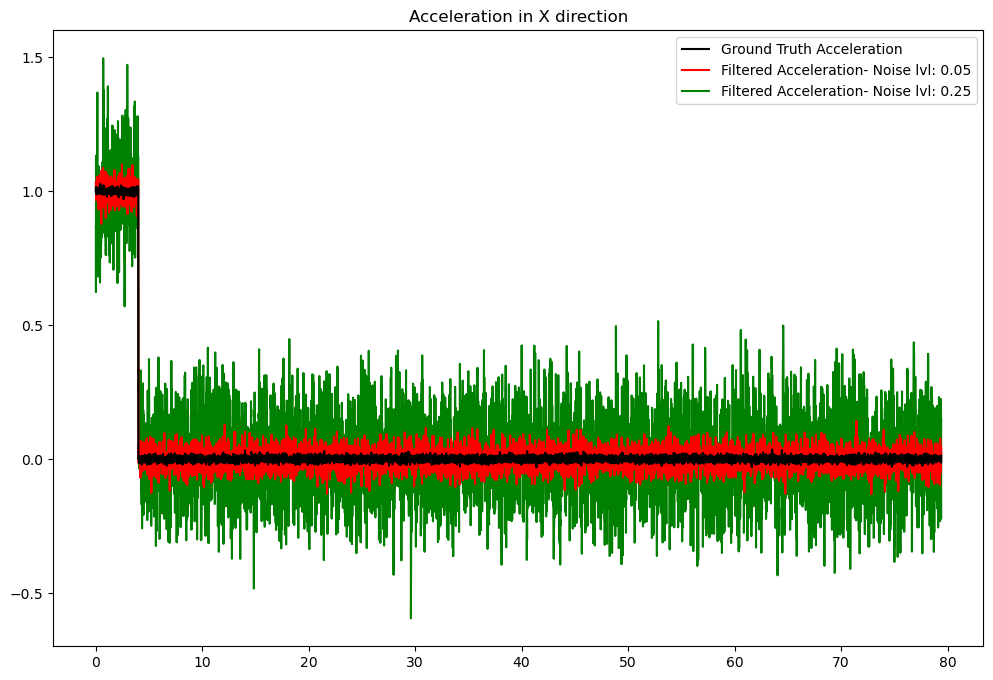

In [431]:
# Plotting acceleration in X direction 
plt.figure(figsize=(12, 8))
plt.plot(time, a_x_1r, label='Ground Truth Acceleration',  color='black', zorder=3)
plt.plot(time, filtered_a_x_1, label='Filtered Acceleration- Noise lvl: 0.05',  color='red', zorder=2)
plt.plot(time, filtered_a_x_2, label='Filtered Acceleration- Noise lvl: 0.25',  color='green', zorder=1)
plt.title('Acceleration in X direction')
plt.legend()

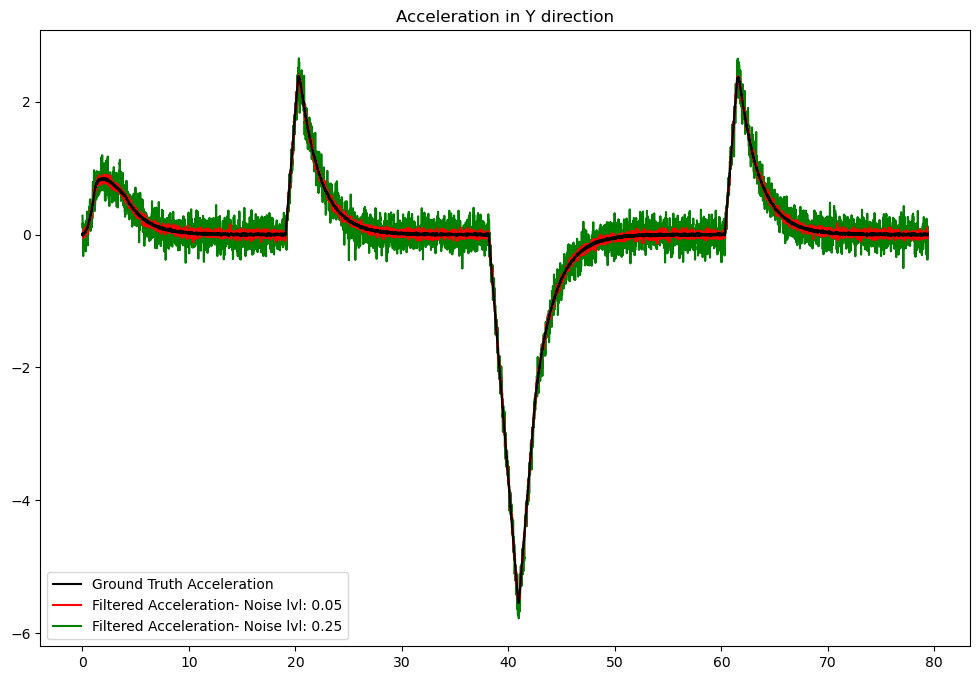

In [432]:
# Plotting acceleration in Y direction
plt.figure(figsize=(12, 8))
plt.plot(time, a_y_1r, label='Ground Truth Acceleration',  color='black', zorder=3)
plt.plot(time, filtered_a_y_1, label='Filtered Acceleration- Noise lvl: 0.05',  color='red', zorder=2)
plt.plot(time, filtered_a_y_2, label='Filtered Acceleration- Noise lvl: 0.25',  color='green', zorder=1)
plt.title('Acceleration in Y direction')
plt.legend()

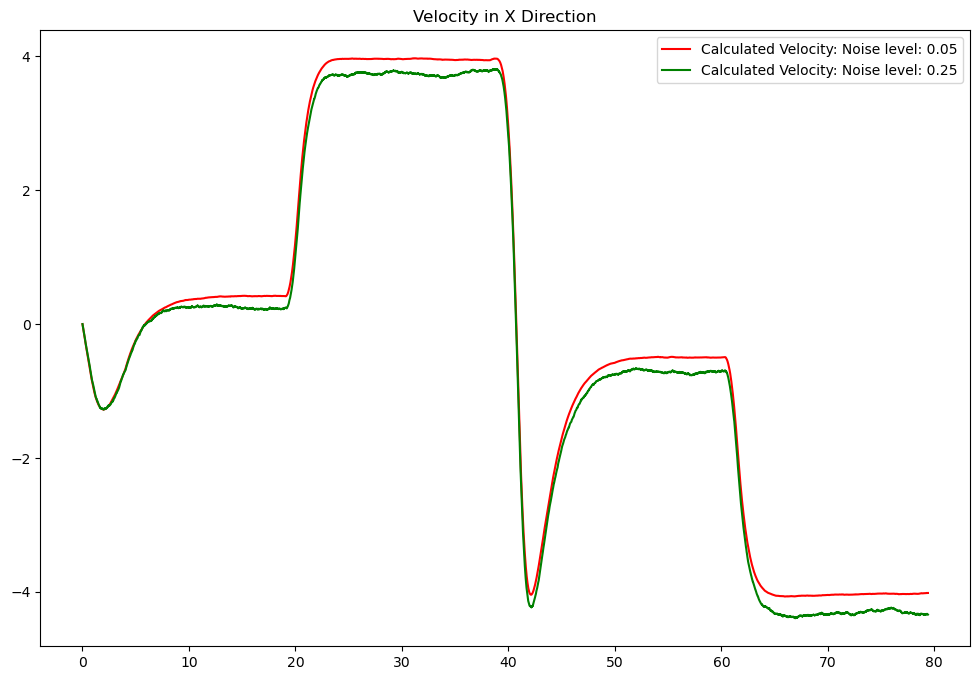

In [433]:
# Plotting velocity in X direction 
plt.figure(figsize=(12, 8))
plt.plot(time, velocities_x_1, label='Calculated Velocity: Noise level: 0.05', color='red')
plt.plot(time, velocities_x_2, label='Calculated Velocity: Noise level: 0.25', color='green')
plt.title('Velocity in X Direction')
plt.legend()
plt.show()

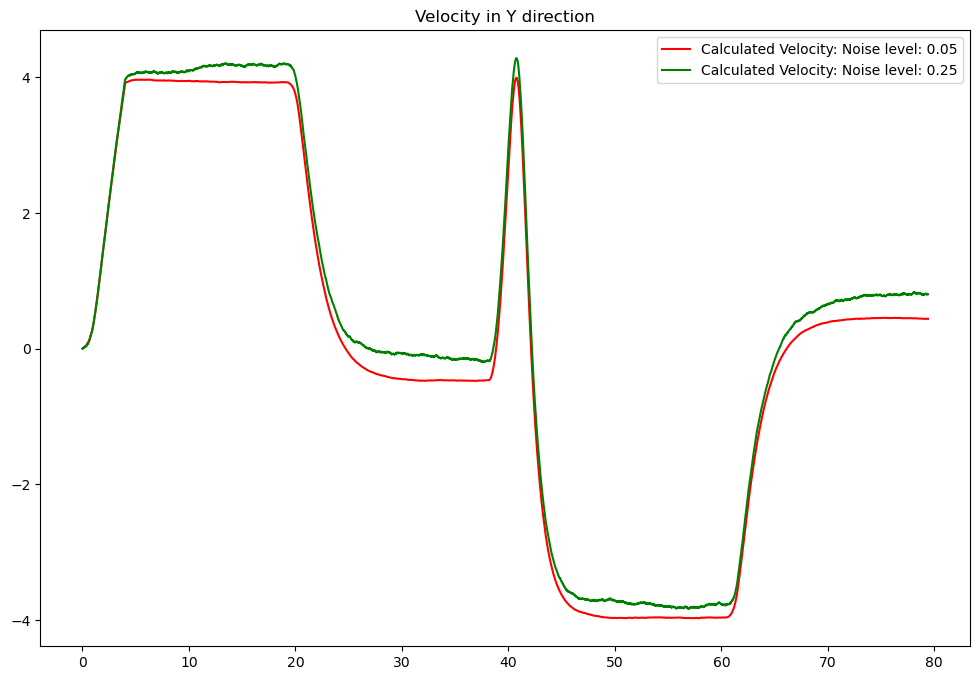

In [434]:
# Plotting velocity in Y direction 
plt.figure(figsize=(12, 8))
plt.plot(time, velocities_y_1, label='Calculated Velocity: Noise level: 0.05', color='red')
plt.plot(time, velocities_y_2, label='Calculated Velocity: Noise level: 0.25', color='green')
plt.title('Velocity in Y direction')
plt.legend()
plt.show()

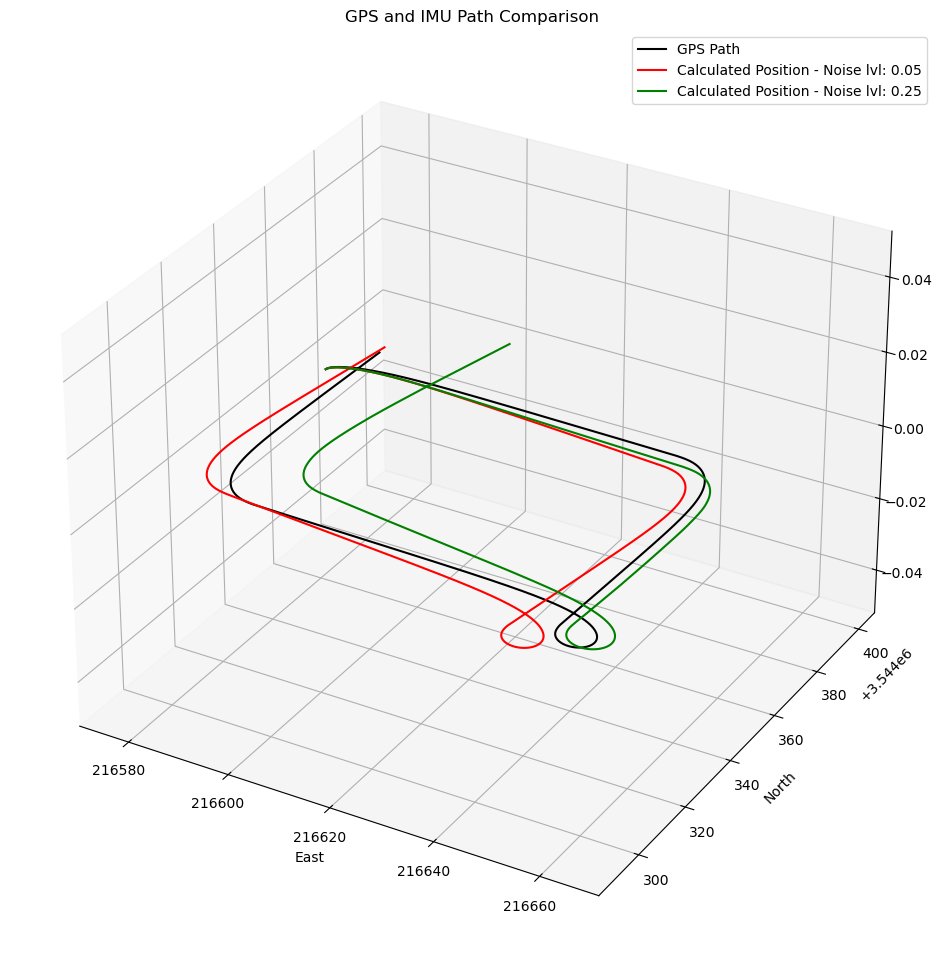

In [435]:
import utm
from mpl_toolkits.mplot3d import Axes3D

gps_lat = gps_csv['ref_gps_lat (deg)']
gps_lon = gps_csv['ref_gps_lon (deg)']

# Convert GPS coordinates to UTM
utm_coords = [utm.from_latlon(lat, lon) for lat, lon in zip(gps_lat, gps_lon)]
utm_x = np.array([coord[0] for coord in utm_coords])
utm_y = np.array([coord[1] for coord in utm_coords])

# Assuming the first UTM coordinate is the origin for IMU data
origin_x, origin_y = utm_x[0], utm_y[0]
imu_x_1_aligned = positions_x_1 + origin_x
imu_y_1_aligned = positions_y_1 + origin_y
imu_x_2_aligned = positions_x_2 + origin_x
imu_y_2_aligned = positions_y_2 + origin_y

plt.figure(figsize=(16, 12))
ax = plt.axes(projection='3d')
plt.plot(utm_x, utm_y, label='GPS Path', linestyle='-', color='black')
plt.plot(imu_x_1_aligned, imu_y_1_aligned, label='Calculated Position - Noise lvl: 0.05', linestyle='-', color='red')
plt.plot(imu_x_2_aligned, imu_y_2_aligned, label='Calculated Position - Noise lvl: 0.25', linestyle='-', color='Green')
plt.xlabel('East')
plt.ylabel('North')
plt.title('GPS and IMU Path Comparison')
plt.legend()
#plt.axis('equal')  # Ensures that one unit in x is of equal length to one unit in y
plt.show()


## Calculate Errors 

In [484]:
gps_time =gps_time_data['gps_time (sec)'].to_numpy()
imu_time = time_data['time (sec)'].to_numpy()

# Downsample the IMU data to match the GPS timestamps
indices = np.searchsorted(imu_time, gps_time)

downsampled_positions_x_imu_1 = positions_x_1[indices-1]
downsampled_positions_y_imu_1 = positions_y_1[indices-1]
downsampled_positions_x_imu_2 = positions_x_2[indices-1]
downsampled_positions_y_imu_2 = positions_y_2[indices-1]

origin_x, origin_y = utm_x[0], utm_y[0]

# Stack the estimated and true positions into arrays
estimated_positions_1 = np.column_stack((downsampled_positions_x_imu_1, downsampled_positions_y_imu_1))
estimated_positions_2 = np.column_stack((downsampled_positions_x_imu_2, downsampled_positions_y_imu_2))
true_positions = np.column_stack((utm_x, utm_y))

distances = np.sqrt(np.sum(np.diff(true_positions, axis=0)**2, axis=1))
total_distance = np.sum(distances)

# Calculate the errors
average_error_1 = np.mean((true_positions - estimated_positions_1) / total_distance)*100
final_error_1 = np.mean((true_positions[-1]-estimated_positions_1[-1])/ total_distance)*100
average_error_2 = np.mean((true_positions - estimated_positions_2) / total_distance)*100
final_error_2 = np.mean((true_positions[-1]-estimated_positions_2[-1])/total_distance)*100

print(f"Average Position Error - Noise lvl: 0.05: {average_error_1} %")
print(f"Final Position Error- Noise lvl: 0.05: {final_error_1} %")
print(f"Average Position Error - Noise lvl: 0.25: {average_error_2} %")
print(f"Final Position Error- Noise lvl: 0.25: {final_error_2} %")

Average Position Error - Noise lvl: 0.05: 607086.4201880165 %
Final Position Error- Noise lvl: 0.05: 607085.1045703102 %
Average Position Error - Noise lvl: 0.25: 607084.0248568148 %
Final Position Error- Noise lvl: 0.25: 607079.664229858 %
